# Sensitivity study: K-means


In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from pathlib import Path
import pickle
import seaborn as sns

from scipy.stats import pearsonr

import skimage
from skimage.exposure import histogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples

import sys
#sys.path.insert(0,'../')
from helper import (classification_tools as ct,
                   visualize as vis)
%matplotlib inline

In [2]:
fc1_path = Path('data','features','VGG16_fc1_features_std.pickle')
assert fc1_path.is_file()

le_path = Path('models','label_encoder.pickle')
assert le_path.is_file()


with open(fc1_path, 'rb') as f:
    data = pickle.load(f)

with open(le_path, 'rb') as f:
    le = pickle.load(f)

In [3]:
files = data['filename']
fc1 = data['features']
labels = data['labels']
y_gt = le.transform(labels)

In [4]:
pca = PCA(n_components=50, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=50, svd_solver='full', whiten=False)
x = pca.fit_transform(fc1)
x_nw = pca_nw.fit_transform(fc1)

C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

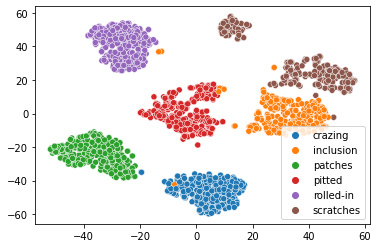

In [5]:
tsne = TSNE(n_components=2, random_state=12214)
x_nw_tsne = tsne.fit_transform(x_nw)
fig, ax = plt.subplots()
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], hue=labels, hue_order=le.labels_ordered)

In [7]:
n_tests=5000
rs = np.random.RandomState(seed=3688757485)
rs_w = rs.randint(2**16, size=n_tests)
rs_nw = rs.randint(2**16, size=n_tests)

use_cache=True
kmeans_acc_vs_inertia_cache_path = Path('.neu_cache','kmeans_acc_vs_inertia.pickle')

if not use_cache or not kmeans_acc_vs_inertia_cache_path.is_file():
    accs_w = np.zeros(n_tests)
    inertias_w = np.zeros(n_tests)
    
    accs_nw = np.zeros(n_tests)
    inertias_nw = np.zeros(n_tests)
    for i, (seed_w, seed_nw) in enumerate(zip(rs_w, rs_nw)):
        
        # cluster results for each random seed, storing the  accuracy and inertia
        kmeans = KMeans(n_clusters=7, init='k-means++', n_init=1, random_state=seed_w)
        kmeans.fit(x)
        y_pred = ct.label_matcher(kmeans.labels_, y_gt)
        CM = confusion_matrix(y_gt, y_pred)
        accs_w[i] = CM.trace()/CM.sum()
        inertias_w[i] = kmeans.inertia_
        
        # repeat for unwhitened components
        kmeans_nw = KMeans(n_clusters=7, init='k-means++', n_init=1, random_state=seed_nw)
        kmeans_nw.fit(x_nw)
        y_pred_nw = ct.label_matcher(kmeans_nw.labels_, y_gt)
        CM_nw = confusion_matrix(y_gt, y_pred_nw)
        accs_nw[i] = CM_nw.trace()/CM_nw.sum()
        inertias_nw[i] = kmeans_nw.inertia_
    with open(kmeans_acc_vs_inertia_cache_path, 'wb') as f:
        pickle.dump({'accs_w': accs_w,
                     'accs_nw': accs_nw,
                     'inertias_w': inertias_w,
                     'inertias_nw': inertias_nw},
                    f)
else:
    with open(kmeans_acc_vs_inertia_cache_path, 'rb') as f:
        results_ = pickle.load(f)
        accs_nw = results_['accs_nw']
        accs_w = results_['accs_w']
        inertias_nw = results_['inertias_nw']
        inertias_w = results_['inertias_w']

In [8]:
def format_hist(data, bins):
    """
    Computes histogram with specified number of bins.
    
    Parameters
    ----------
    data: ndarray
        n-element array of data from which to compute histogram
    
    bins: int
        number of bins to use in histogram
    
    Returns
    ---------
    hist: ndarray
        *bins* element array of counts from the histogram
    
    bin_centers: ndarray
        *bins* element array where each item is the center of the bin in the histogram 
    
    """
    hist, bin_edges = np.histogram(data, bins=bins)
    bin_centers = np.asarray([np.mean([x,y]) for x,y in zip(bin_edges[:-1], bin_edges[1:])])
    
    return hist, bin_centers
    
hist_w, bins_w = format_hist(accs_w, bins=20)

hist_nw, bins_nw = format_hist(accs_nw, bins=20)

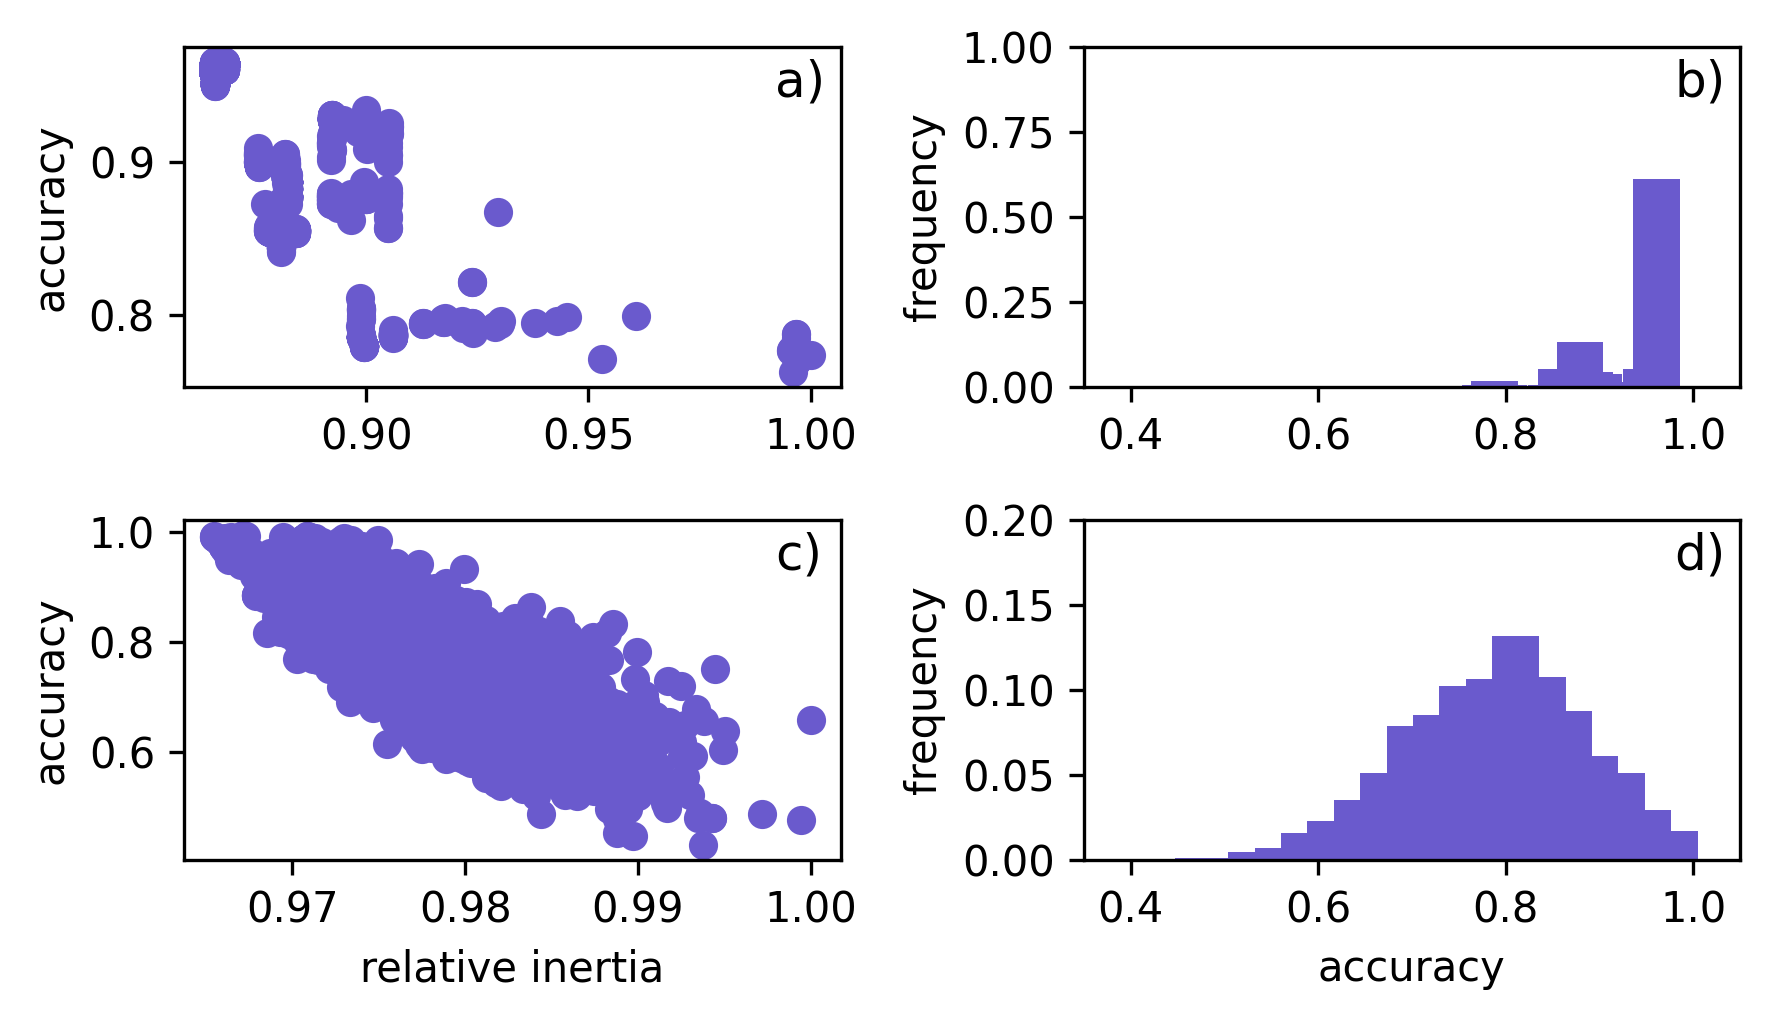

In [9]:
fig, axs = plt.subplots(2,2, figsize=(6,3.5), dpi=300,facecolor='w')

ax = axs[0,0]
ax.plot(inertias_nw/inertias_nw.max(), accs_nw, 'o', color='slateblue')

ax = axs[0,1]
ax.bar(bins_nw, hist_nw/hist_nw.sum(), width=0.05, color='slateblue')
ax.set_xlim([0.35, 1.05])

ax.set_yticks(np.linspace(0,1,5), minor=True)

ax = axs[1,0]
ax.plot(inertias_w/inertias_w.max(), accs_w, 'o', color='slateblue')
ax.set_xlabel('relative inertia')


ax = axs[1,1]
ax.bar(bins_w, hist_w/hist_w.sum(), width=0.05, color='slateblue')
ax.set_xlim([0.35, 1.05])
ax.set_yticks(np.linspace(0,0.2,5), minor=True)
ax.set_xlabel('accuracy')


for a in axs[:,1].ravel():
    a.set_ylabel('frequency')
for a in axs[:,0].ravel():
    a.set_ylabel('accuracy')

for a, title in zip(axs.ravel(), ['a','b','c','d']):
    a.set_title("{})".format(title), loc='left', **{'x':0.9,'y':0.78})

fig.tight_layout()
fig.savefig(Path('Figures','kmeans_n_iter.png'), bbox_inches='tight')

In [10]:
print('No Whitening')
print('\tmin acc: \t{:.3f}\n\tmax acc:\t{:.3f}\nacc-min inertia:\t{:.3f}\n'.format(
    accs_nw.min(), accs_nw.max(), accs_nw[inertias_nw.argmin()]))

print('With Whitening')
print('\tmin acc: \t{:.3f}\n\tmax acc:\t{:.3f}\nacc-min inertia:\t{:.3f}'.format(
    accs_w.min(), accs_w.max(), accs_w[inertias_w.argmin()]))

No Whitening
	min acc: 	0.763
	max acc:	0.966
acc-min inertia:	0.964

With Whitening
	min acc: 	0.431
	max acc:	0.994
acc-min inertia:	0.993


In [11]:
print('No whitening')
print('\ttop bin accuracy:\t{:.3f}\n\ttop bin fraction:\t{:.3f}\n\n'
      .format(bins_nw[-2], hist_nw[-1]/hist_nw.sum()))
bins_nw[-2]

print('With whitening')
print('\ttop bin accuracy:\t{:.3f}\n\ttop bin fraction:\t{:.3f}'
      .format(0.99, (accs_w > 0.99).sum()/len(accs_w)))

No whitening
	top bin accuracy:	0.950
	top bin fraction:	0.611


With whitening
	top bin accuracy:	0.990
	top bin fraction:	0.002


In [12]:
bins_w[hist_w.argmax():hist_w.argmax()+2]


array([0.81080556, 0.83897222])

In [13]:
print('Pearson r correlation between accuracy and inertia')
print('whitening: \t{:.3f}'.format(pearsonr(inertias_w, accs_w)[0]))
print('no whitening:\t{:.3f}'.format(pearsonr(inertias_nw, accs_nw)[0]))

Pearson r correlation between accuracy and inertia
whitening: 	-0.785
no whitening:	-0.830


## Influence of number of clusters on accuracy
 

In [14]:
use_cache = True
kmeans_k_cache_path = Path('.neu_cache','kmeans_acc_vs_k.pickle')

if not use_cache or not kmeans_k_cache_path.is_file():
    k_values = np.arange(6,26)
    acc_k = np.zeros(k_values.shape)
    rs = np.random.RandomState(seed=3689319368)
    
    
    for i, (k, state) in enumerate(zip(k_values, rs.randint(2**16,size=len(k_values)))):

        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=500, random_state=state)
        kmeans.fit(x)
        y_pred = ct.label_matcher(kmeans.labels_, y_gt)
        CM = confusion_matrix(y_gt, y_pred)
        acc_k[i] = CM.trace()/CM.sum()
    
    with open(kmeans_k_cache_path, 'wb') as f:
        pickle.dump({'k_values': k_values,
                    'acc_k': acc_k},
                    f)
else:
    with open(kmeans_k_cache_path, 'rb') as f:
        results_ = pickle.load(f)
        k_values = results_['k_values']
        acc_k = results_['acc_k']
    

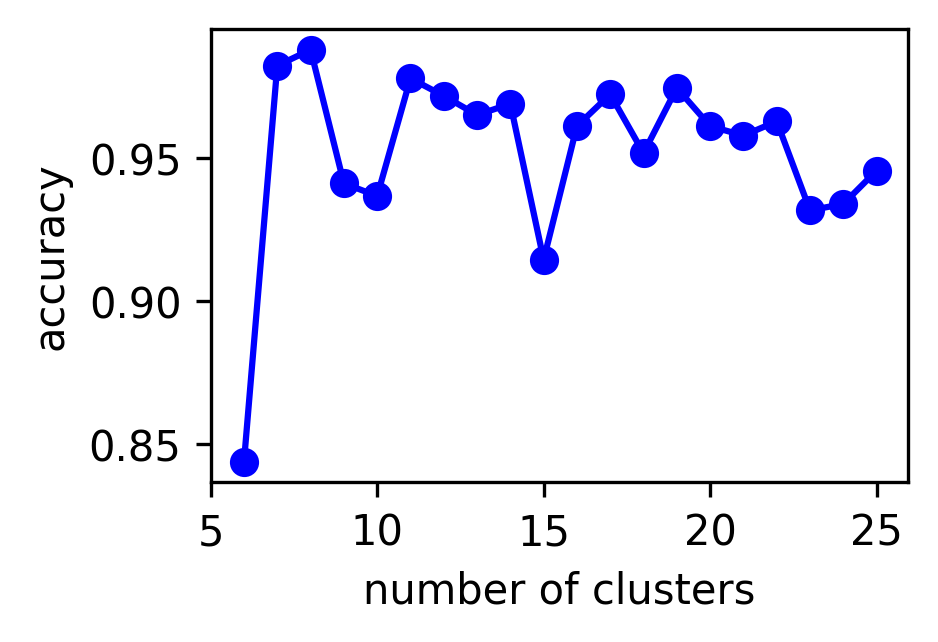

In [15]:
fig, ax = plt.subplots(dpi=300, figsize=(3,2))
ax.plot(k_values, acc_k, '-bo')
#ax[1].plot(K, [np.median(x) for x in silhouettes], ':o')
ax.set_xticks(range(5,26,5))
ax.set_xlabel('number of clusters')
ax.set_ylabel('accuracy')
plt.show()

In [17]:
rs2 = np.random.RandomState(seed=3689319368)
k_ = np.arange(6,25)
states = rs2.randint(2**16, size=k_.shape)

i = 8


kmeans = KMeans(n_clusters=k_[i], init='k-means++', n_init=500, random_state=states[i])
kmeans.fit(x)
y_pred = ct.label_matcher(kmeans.labels_, y_gt)
CM = confusion_matrix(y_gt, y_pred)
acc = CM.trace()/CM.sum()

In [18]:
cluster_mapper = {}
for p in np.unique(y_pred):
    y_clusters = kmeans.labels_[y_pred == p]
    for idx, value in enumerate(np.unique(y_clusters)):
        cluster_mapper[value] = '{}-{}'.format(le.inverse_transform([p])[0], idx)
    

C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


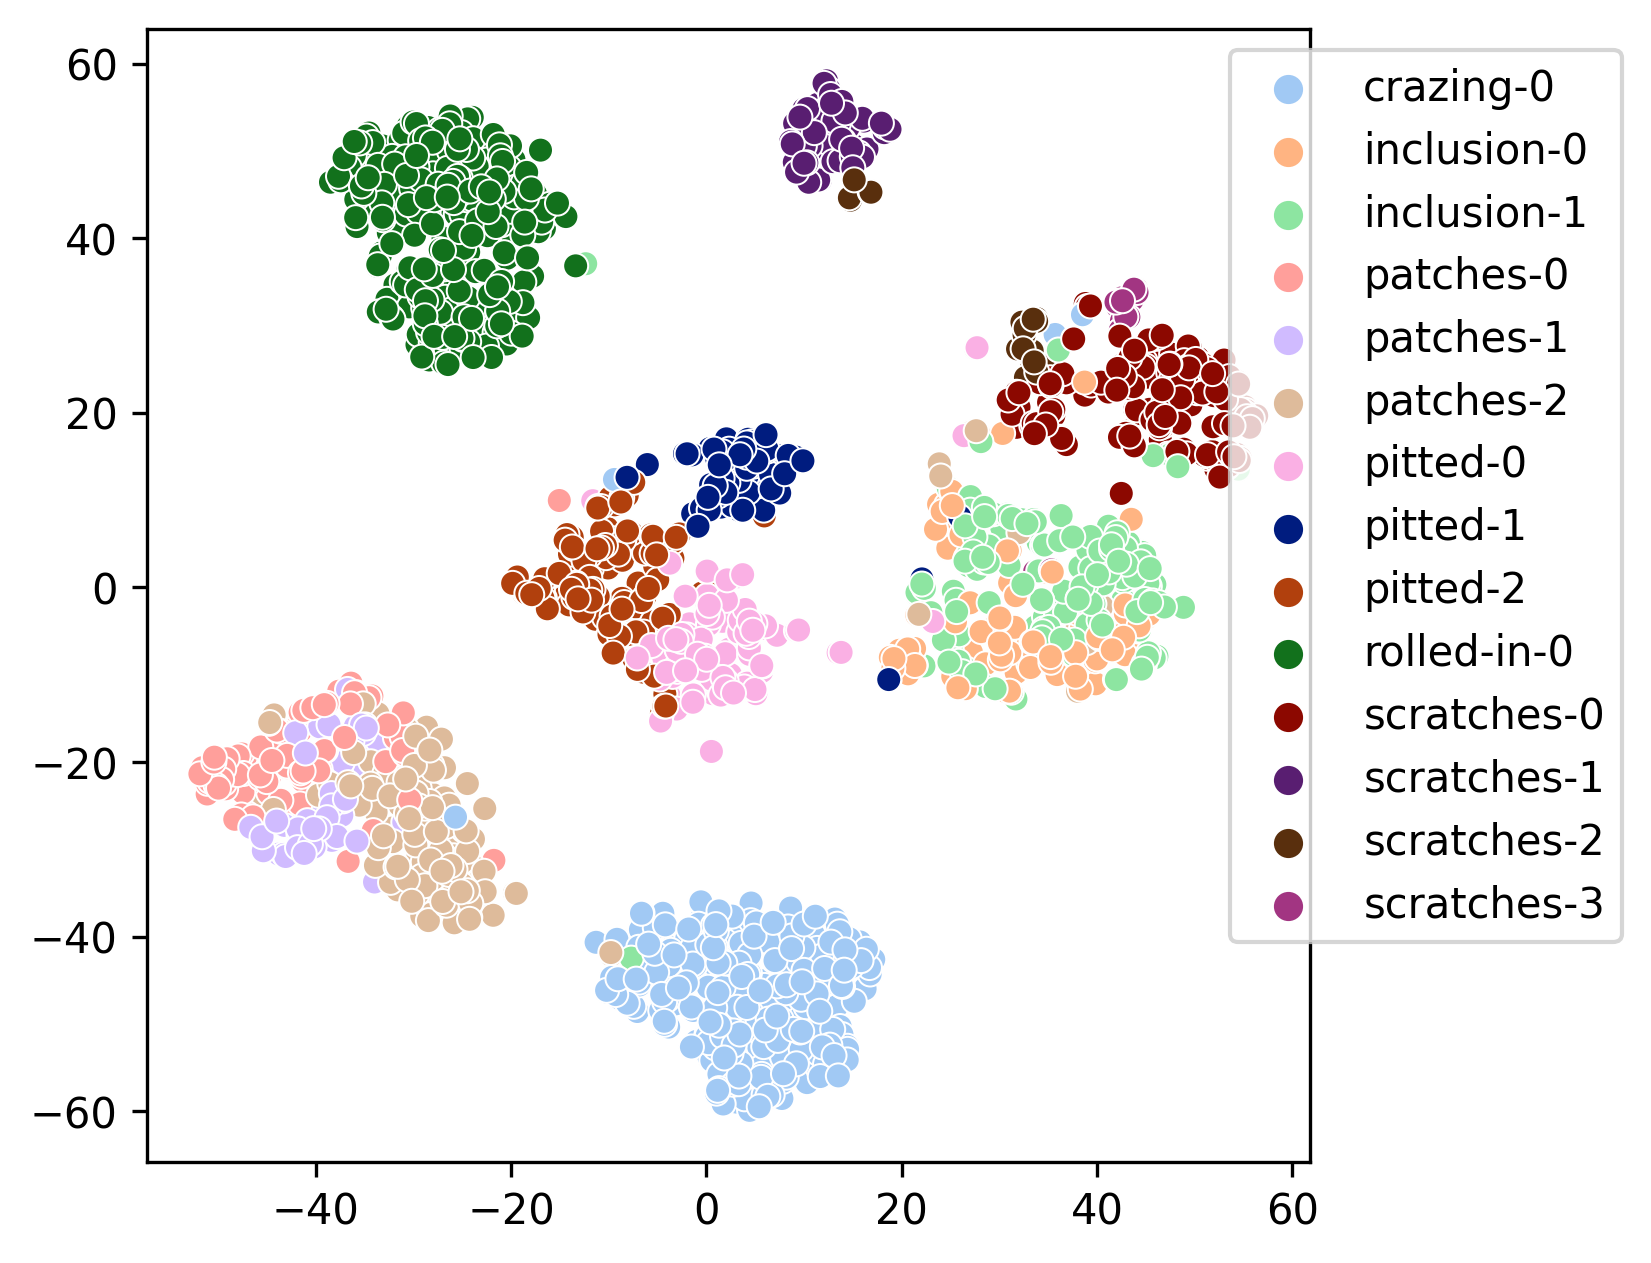

In [19]:
palette = np.concatenate((sns.color_palette('pastel', 7), sns.color_palette('dark', 7)), axis=0)
hue = [cluster_mapper[x] for x in kmeans.labels_]
hue_order=sorted(cluster_mapper.values(), key=lambda x: x.upper())


fig, ax = plt.subplots(dpi=300, figsize=(5,5))
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], hue=hue, hue_order=hue_order, palette=dict(zip(hue_order, palette)), ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(1.1,1))